In [1]:
%matplotlib inline
import rebound as r
r.reset()
import numpy as np
import matplotlib.pyplot as plt
r.status()
from IPython.html.widgets import interact, interactive
from IPython.display import display

---------------------------------
Rebound version:     	1.1.0
Build on:            	Jun 21 2015 16:09:56
Number of particles: 	0
Simulation time:     	0.000000
---------------------------------


:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Simulated data:

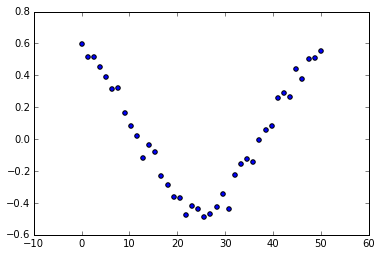

In [2]:
data_N = 40
data_t = np.linspace(0.,50.,data_N)+0.0005*np.random.rand(data_N)
data_rv = 0.500883379885605*(np.sin(2.*np.pi*data_t/50.+np.pi/2.)+0.4*(np.random.rand(data_N)-0.5))
plt.scatter(data_t, data_rv);

## Setting up simulations

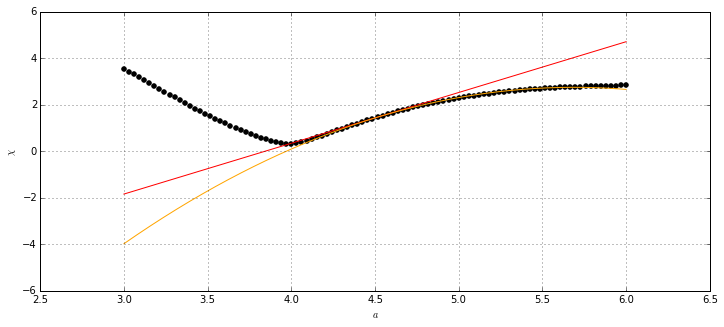

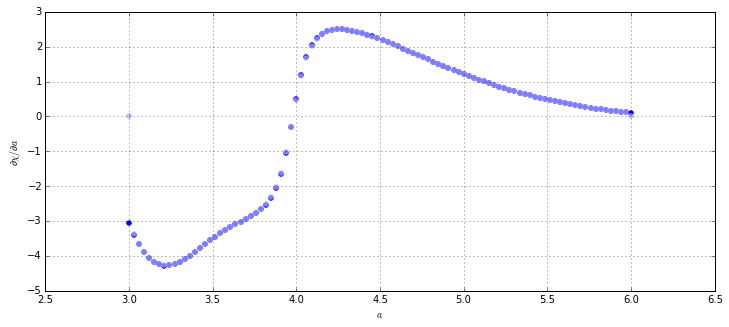

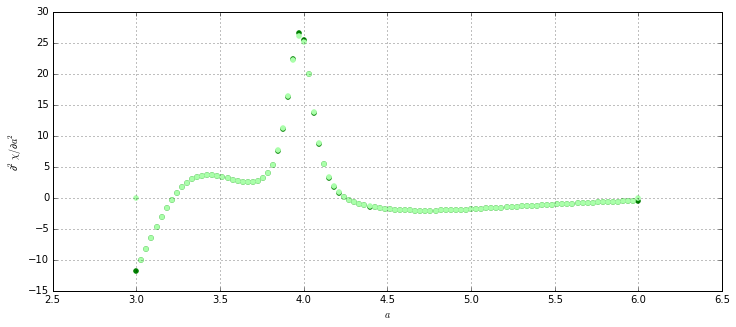

In [4]:
numvar = 4
N = 2
def varid2(l,k):
    var = l*(l+1)/2+k
    return var*N+1+N+N*numvar
def varid1(l):
    return N*l+1+N
    
def simulation(cart):
    r.reset()
    r.N_megnopp = numvar 
    r.add(m=1.)
    op = r.Particle(a=cart[0],e=cart[1],anom=cart[2],omega=cart[3])
    r.add(op)
    N = r.N
    r.init_megno(0.)
    ps = r.particles
    
    
    delta = 1e-4
    # First order
    for l in range(numvar):
        cart2 = cart.copy()
        cart2[l] += delta
        mp = r.Particle(primary=ps[0],a=cart2[0],e=np.clip(cart2[1],0.,0.9),anom=cart2[2],omega=cart2[3])

        vari = varid1(l)
        ps[vari].x  = (mp.x  - ps[1].x  )
        ps[vari].y  = (mp.y  - ps[1].y  )
        ps[vari].z  = (mp.z  - ps[1].z  )
        ps[vari].vx = (mp.vx - ps[1].vx )
        ps[vari].vy = (mp.vy - ps[1].vy )
        ps[vari].vz = (mp.vz - ps[1].vz )
        
    # Second order
    for l in range(numvar):
        for k in range(l+1):
            cart2 = cart.copy()
            cart2[l] += delta
            mp = r.Particle(primary=ps[0],a=cart2[0],e=np.clip(cart2[1],0.,0.9),anom=cart2[2],omega=cart2[3])
            cart2[l] -= 2.*delta
            mm = r.Particle(primary=ps[0],a=cart2[0],e=np.clip(cart2[1],0.,0.9),anom=cart2[2],omega=cart2[3])
            
            vari2 = varid2(l,k)
            ps[vari2].x  = mp.x  - 2.*ps[1].x  + mm.x
            ps[vari2].y  = mp.y  - 2.*ps[1].y  + mm.y 
            ps[vari2].z  = mp.z  - 2.*ps[1].z  + mm.z 
            ps[vari2].vx = mp.vx - 2.*ps[1].vx + mm.vx
            ps[vari2].vy = mp.vy - 2.*ps[1].vy + mm.vy
            ps[vari2].vz = mp.vz - 2.*ps[1].vz + mm.vz
    
    
    ##################################################################
    # INTEGRATION
    sim_rv = 0.
    sim_rvd = np.zeros(numvar)
    sim_rvd2 = np.zeros((numvar*(numvar+1)/2,2))
    for i,t in enumerate(data_t):
        r.integrate(t)
        dv = ps[1].vx-data_rv[i]
        sim_rv  += dv**2
        for k in range(numvar):
            vari1 = varid1(k)
            sim_rvd[k] += 2.*(ps[vari1].vx) * (dv+ps[vari1].vx)
        _id = 0
        for l in range(numvar):
            for k in range(l+1):
                vari2 = varid2(l,k)
                vari1 = varid1(l)
                f = dv+ps[vari1].vx+0.5*ps[vari2].vx
                sim_rvd2[_id][0] += 2.*ps[vari2].vx*f + 2.*(ps[vari1].vx+ps[vari2].vx)**2
                sim_rvd2[_id][1] += 2.*(ps[vari2].vx+ps[vari1].vx)*f

                _id += 1
    err  = np.sqrt(sim_rv)
    errd = sim_rvd/(2.*delta*err)

    
    errd2m = np.zeros((numvar,numvar))
    _id = 0
    for l in range(numvar):
        for k in range(l+1):
            fdd =   sim_rvd2[_id][0]/(2.*(delta**2)*err) - (sim_rvd2[_id][1])**2/(4.*(delta**2)*(err**3))
            errd2m[l,k] = fdd
            errd2m[k,l] = fdd
            _id +=1
    
    return err, errd, errd2m
a0 = np.array([4.0,0.01,0.,-np.pi/2.]) # initial parameters
a = a0.copy()

N_grid = 100
a_s = np.linspace(3.0,6.0,N_grid)

errs = np.zeros(N_grid)
gradients = np.zeros(N_grid)
hessians = np.zeros(N_grid)

for i,at in enumerate(a_s):
    a[0] = at
    err, gradient, hessian = simulation(a)
    errs[i] = err
    gradients[i] = gradient[0]
    lasthessian = hessian
    hessians[i] = hessian[0,0]
    

        
def widget_plot(ind):
    ind = int(ind)
  
    def f(a,i):
        da = a - a_s[i] 
        return errs[i] + gradients[i]*da,  errs[i] + gradients[i]*da + 0.5*hessians[i]*da*da
    
    a_s_fine = np.linspace(a_s[0],a_s[-1],N_grid*10)
    err_fine = np.zeros(N_grid*10)
    err_fine2 = np.zeros(N_grid*10)
    for i,a in enumerate(a_s_fine):
        err_fine[i], err_fine2[i] = f(a,ind)
        
    gradient_direct = np.zeros(N_grid)
    hessian_direct  = np.zeros(N_grid)
    for i,a in enumerate(a_s_fine):
        if i>0 and i<N_grid-1:
            gradient_direct[i] = (errs[i+1]-errs[i-1])/(a_s[i+1]-a_s[i-1])
            hessian_direct[i]  = (errs[i+1]-2.*errs[i]+errs[i-1])/((a_s[i+1]-a_s[i])*(a_s[i]-a_s[i-1]))
            
 
    fig1 = plt.figure(figsize=(12,5))
    plt.ylabel("$\chi$"); plt.xlabel("$a$")
    plt.scatter(a_s, errs, color="k");   
    plt.plot(a_s_fine, err_fine, color="r");
    plt.plot(a_s_fine, err_fine2, color="#FFA500");
    plt.grid()
    
    fig2 = plt.figure(figsize=(12,5))
    plt.ylabel("${\partial \chi}/{\partial a}$"); plt.xlabel("$a$")
    plt.scatter(a_s, gradients, color="b");
    plt.scatter(a_s, gradient_direct, color="#aaaaff",alpha=0.7);
    plt.grid()
    
    
    fig3 = plt.figure(figsize=(12,5))
    plt.ylabel("${\partial^2 \chi}/{\partial a^2}$"); plt.xlabel("$a$")
    plt.scatter(a_s, hessians, color="g");
    plt.scatter(a_s, hessian_direct, color="#aaffaa");
    plt.grid()

w = interactive(widget_plot, ind=(0,N_grid))

display(w)

In [7]:
print lasthessian

[[-0.48923397 -1.11228811  3.26608063  3.35419984]
 [-1.11228811  0.0490618   3.53483218  3.56682179]
 [ 3.26608063  3.53483218 -0.17423856 -0.17314766]
 [ 3.35419984  3.56682179 -0.17314766 -0.22766306]]
